In [1]:
from z3 import *
import numpy as np
import re
import arviz as az
import matplotlib.pyplot as plt
plt.rcParams["figure.autolayout"] = True # to for tight_layout()

import os, sys
sys.path.append(os.path.join("../../../"))

from src.mcmc_sat import smt, mcmc, sat, utils

## Debugging bit overflow

We have detected an issue in the Hazelton case study when analyzed with spur. It seems to be an overflow issue. This notebook is just a temporary one to try to debug it.

In [2]:
# parameters of the model
num_bits = 9
num_vars = 2

# model
var_list = [BitVec(f'x{i}',num_bits) for i in range(num_vars)]
x = var_list
g = Goal()

# printing g seems that these two functions work as intended
sat.add_bool_vars_to_goal(g, var_list)
g.add(sat.addition_does_not_overflow(x))

# pringint g, these also seem to be correct
for i in range(num_vars):
    g.add(ULE(0,x[i]))
    g.add(ULE(x[i],(2**(num_bits-1))-1))

g.add(x[0] + x[1] == 300)

In [2]:
y=np.array([1087, 1008, 1068, 1204, 1158, 1151, 1143])
num_con = 3
yprime  = np.array([4*int(i/10) for i in y[:num_con]]) #y[:num_con]
print(yprime)

[432 400 424]


In [3]:
# Assumption, all bit-vectors are of the same size
num_bits = 10
num_vars = 6
var_list = [BitVec(f'x{i}',num_bits) for i in range(num_vars)]
x = var_list
g = Goal()

sat.add_bool_vars_to_goal(g, var_list)
g.add(sat.addition_does_not_overflow([x[0], x[1], x[2]]))
g.add(sat.addition_does_not_overflow([x[1], x[2], x[3], x[4]]))
g.add(sat.addition_does_not_overflow([x[2], x[4], x[5]]))

for i in range(num_vars):
    g.add(ULE(0,x[i]))
    g.add(ULE(x[i],(2**(num_bits-2))-1))

g.add(x[0] + x[1] + x[2] == yprime[0])
g.add(x[1] + x[2] + x[3] + x[4] == yprime[1]) 
g.add(x[2] + x[4] + x[5]  == yprime[2])

In [2]:
A = np.array([[1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0],
[0,0,0,1,1,1,1,0,0,1,1,1,1,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0],
[0,0,0,0,1,1,1,0,0,0,1,1,1,0,0,1,1,1,0,1,1,1,1,1,1,0,0,0],
[0,0,0,0,0,1,1,0,0,0,0,1,1,0,0,0,1,1,0,0,1,1,0,1,1,1,1,0],
[0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,1,1]])

y=np.array([1087, 1008, 1068, 1204, 1158, 1151, 1143])

num_bits = 12
max_int_bv = 2**8

num_vars = A.shape[1]
num_ys   = y.shape[0]

x = [BitVec(f'x{i}', num_bits) for i in range(num_vars)]

g = Goal()

sat.add_bool_vars_to_goal(g, x)

for i in range(num_vars):
    g.add(ULE(0, x[i]))
    g.add(ULE(x[i], max_int_bv))


for i in range(len(y)):
    vars_ = [x[j] for j in range(num_vars) if A[i][j] == 1]
    g.add(sat.addition_does_not_overflow(vars_))
    g.add(Sum(vars_) == y[i])

In [ ]:
[print(cons) for cons in g]

As a sanity check, we verify that the SMTproblem has a solution

In [4]:
# sanity check (optional)
solve(g)

[x00 = False,
 x06 = False,
 x51 = True,
 x27 = True,
 x29 = False,
 x18 = False,
 x45 = True,
 x43 = True,
 x40 = True,
 x34 = False,
 x23 = False,
 x52 = False,
 x30 = True,
 x55 = True,
 x20 = True,
 x10 = True,
 x16 = False,
 x32 = True,
 x56 = False,
 x41 = False,
 x05 = False,
 x01 = True,
 x44 = True,
 x33 = False,
 x35 = False,
 x53 = True,
 x54 = False,
 x57 = True,
 x42 = False,
 x37 = False,
 x21 = False,
 x25 = False,
 x26 = False,
 x36 = False,
 x47 = False,
 x46 = True,
 x12 = True,
 x50 = False,
 x17 = True,
 x19 = False,
 x31 = False,
 x48 = False,
 x59 = False,
 x39 = False,
 x38 = False,
 x49 = False,
 x58 = False,
 x24 = False,
 x02 = True,
 x13 = True,
 x22 = True,
 x11 = False,
 x09 = False,
 x15 = False,
 x07 = True,
 x28 = False,
 x03 = True,
 x14 = False,
 x04 = True,
 x08 = False,
 x4 = 121,
 x5 = 170,
 x3 = 5,
 x2 = 133,
 x0 = 158,
 x1 = 141]


## Bit-blasting

The function below bit-blasts the problem and stores it in CNF form in the specified directory and file. The bit-blasted problem is stored in DIMACS format. This is one for the input formats that `spur` supports.

The `save_dimacs` function returns a pair with two elements. 

The first one is that number of variables in the bit-blasted problem (`num_variables`)---do not confuse this variable with `num_vars`, which is the number of variables in the original SMT problem. The resulting bit-blasted problem is a SAT problem.

The second element `variables_number` is a map `int -> Z3_VAR` that assigs a natural number to each bit-blasted variable. This map is necessary to reverse the bit-blasting process after obtaining the samples from `spur`.

In [4]:
 t = z3.Then('simplify', 'bit-blast', 'tseitin-cnf')
 subgoal = t(g)
 assert len(subgoal) == 1

# for c in subgoal[0]:
#     print(c)

count_vars = 0
map_vars_nums = {}
map_nums_vars = {}
dimacs_clauses = [[]]


# subgoal[0] contains all clauses so we iterate over them
for c in subgoal[0]:    
    # temp var to store processed clause
    clause = [] 
    # iterate over literals of a clause
    for i in range(c.num_args()): 
        # if the clause has only one literal then the clause is the literal (it is of the form ¬x)
        # otherwise (it has from l_0 \/ l_1 \/ ...) and we use arg(i) to select the literal
        lit = c.arg(i) if c.num_args() > 1 else c 
        # check whether the literal is the negation, i.e., ¬x
        negation = z3.is_app_of(lit, z3.Z3_OP_NOT)
        # if negated the variable is arg(0) otherwise the literal is the variable 
        var = lit.arg(0) if negation else lit
        # if the variable is not a value in the map num -> var, then we add it
        if var not in map_nums_vars.values():
            # we select a new var number (for dimacs cnf format)
            count_vars = count_vars + 1
            # added to the two maps num -> var and var -> num
            map_vars_nums[var] = count_vars
            map_nums_vars[count_vars] = var
        # we append a string modeling the literal in dimacs cnf format
        clause.append(('-' if negation else '')+str(map_vars_nums[var]))
    # we add the end of line character for dimacs cnf format
    dimacs_clauses.append(clause+['0'])


# we add the header of the dimacs cnf format
n_varibles = len(map_vars_nums.keys())
n_constraints = len(dimacs_clauses)-1
s = "p cnf " + str(n_varibles) + " " + str(n_constraints)
dimacs_clauses[0].append(s)


# save the result in to a file
input_dir = 'spur_input'
input_file = 'raul.cnf'

output_filepath = f'{input_dir}/{input_file}'

with open(output_filepath, 'w') as file:
    for row in dimacs_clauses:
        file.write(' '.join([str(item) for item in row]))
        file.write('\n')


# return the number of variables (after bit-blasting) and the map num -> var
(num_variables, variables_number) = (n_varibles, map_nums_vars)
# print(map_nums_vars)
# print(map_vars_nums)

In [7]:
m = {'a': 2, 'b': 3}

True

In [5]:
input_dir = 'spur_input'
input_file = 'Database2.cnf'
(num_variables, variables_number) = sat.save_dimacs(g, 
                                                    f'{input_dir}/{input_file}')

Here we call `spur` using the input file created in the previous step. We instruct it to generate 10000 samples. The output samples are stored in the same directory as the input file, and the output file is named `samples_<input_file>.txt`.

In [6]:
num_samples   = 100
sat.execute_spur(f'{input_dir}/{input_file}',num_samples=num_samples)

Using default filename: "spur_input/samples_Database2.txt"
Performing Uniform Model Sampling...
Input File:  spur_input/Database2.cnf
Output File: spur_input/samples_Database2.txt

Preprocessing ... DONE
variables (all/used/free): 	568/568/0
independent support size:  	0
clauses (all/long/binary/unit): 2400/1837/531/32
Initialize cache
Size of Cacheable Component:	56
Size of MPZ Class:	16
Maximum cache size:	3151 MB

STAGE #1: Build the initial partial assignments



time elapsed: 60.4577s


STAGE #1: COMPLETED building initial partial assignments
STAGE #2 - Filling in partial assignments...


Initialize cache
Size of Cacheable Component:	56
Size of MPZ Class:	16

 Free RAM 2964MB
Maximum cache size:	3151 MB

Completing sample #1 of 97 which has 76 variables unset and 1 sample.
Completing sample #2 of 97 which has 56 variables unset and 1 sample.
Completing sample #3 of 97 which has 146 variables unset and 1 sample.
Completing sample #4 of 97 which has 124 variables unset and 1 sample.
Completing sample #5 of 97 which has 98 variables unset and 1 sample.
Completing sample #6 of 97 which has 166 variables unset and 1 sample.
Completing sample #7 of 97 which has 176 variables unset and 1 sample.
Completing sample #8 of 97 which has 108 variables unset and 1 sample.
Completing sample #9 of 97 which has 44 variables unset and 1 sample.
Completing sample #10 of 97 which has 60 variables unset and 1 sample.
Completing sample #11 of 97 which has 68 variables unset and 1 sample.
Completing sample #12 of 97 which has 97 variables unset and 1 sample.
Completing sample #13 of 97 which 

Completing sample #47 of 97 which has 167 variables unset and 1 sample.
Completing sample #48 of 97 which has 165 variables unset and 1 sample.
Completing sample #49 of 97 which has 84 variables unset and 1 sample.
Completing sample #50 of 97 which has 209 variables unset and 1 sample.
Completing sample #51 of 97 which has 139 variables unset and 1 sample.
Completing sample #52 of 97 which has 130 variables unset and 1 sample.
Completing sample #53 of 97 which has 140 variables unset and 1 sample.
Completing sample #54 of 97 which has 57 variables unset and 1 sample.
Completing sample #55 of 97 which has 100 variables unset and 1 sample.
Completing sample #56 of 97 which has 140 variables unset and 1 sample.
Completing sample #57 of 97 which has 109 variables unset and 1 sample.
Completing sample #58 of 97 which has 122 variables unset and 1 sample.
Completing sample #59 of 97 which has 130 variables unset and 1 sample.
Completing sample #60 of 97 which has 165 variables unset and 1 sa

Completing sample #97 of 97 which has 24 variables unset and 1 sample.
STAGE #2 - COMPLETE


variables (total / active / free)	568/568/0
clauses (removed) 		2400 (0)
decisions 				418589
conflicts 				5240
conflict clauses (all/bin/unit) 	72257/202/32
failed literals found by implicit BCP 	 55765
implicit BCP miss rate 	99.7433%
bytes cache size     	181246120	
bytes cache (overall) 	181277244
bytes cache (infra / comps) 20234408/161011712	
bytes pure comp data (curr)    134225936
bytes pure comp data (overall) 134253524
bytes cache with sysoverh (curr)    186961488
bytes cache with sysoverh (overall) 186996040
cache (stores / hits) 			418528/361281
cache miss rate 		53.6742%
avg. variable count (stores / hits) 	163.805/69.585


# solutions 
3426815

# END

time: 118.414s


Total Sampler Execution Time: 118.414s

#START_HEADER
start_time,Wed Feb 21 14:37:20 2024
formula_file,spur_input/Database2.cnf
num_vars,568
independent_support_size,0
num_clauses,2400
tot_num_models,3426815
max_com

The function below parses the samples generated by `spur`. It returns a matrix with coordinates (sample, bit-blasted_var) containing all generated samples. That is, each row correspond a sample, and each column contains the value of a bit-blasted variable.

For now, the function takes as input the input directory and file for `spur`. That is, the same parameters as the previous function. The function below automatically infers the name of file containing the samples generated by `spur`.

In [7]:
samples = sat.parse_spur_samples(input_dir, input_file, 
                                 num_samples, num_variables)

The function below performs an intermediate step where we create a map from z3 bit-blasted variables to their sampled values, i.e., Z3_VAR -> list[bool].

In [8]:
map_variable_values = sat.map_spur_samples_to_z3_vars(variables_number, 
                                                      num_variables,
                                                      samples)

## Reverse bit-blasting

Finally, we take the map above to reverse the bit-blasting process for each of the spur samples. The function below returns a list of dictionaries. Each dictionary contains a sample value for the SMT problem variables (i.e., reverse-bit-blasted variables). This output format is expected output for our `mcmc.sample_mh_trace` function.

The function below takes as input the map from Z3 bit-blasted variables to values, the number of generated samples, the number of varibles (**in the SMT problem**), and the number of bits of the bit-vectors of the SMT problem. We emphasize again that the number of variables in this function refers to the number of bit-vectors in the SMT problem. Do not confuse with the number of variables in the bit-blasted SAT problem.

Here we note an important requirement of this process. All bit-vectors must have the same number of bits.

In [16]:
def reverse_bit_blasting_new(variable_values: dict[str, list[bool]],
                             num_samples: int,
                             num_vars: int,
                             num_bits: int) -> list[dict[str, int]]:

    def __from_bin_to_dec(i, s, num_bits, map_variable_values):
        x = f'x{i}'
        total = 0
        for j in range(num_bits):
            total += 2**j * map_variable_values[f'{x}{j}'][s]
        return total

    solver_samples = [ {f'x{i}': __from_bin_to_dec(i, s, num_bits, variable_values) for i in range(num_vars)} for s in range(num_samples) ]

    return solver_samples


In [9]:
solver_samples = sat.reverse_bit_blasting_simp(map_variable_values, 
                                               num_samples,
                                               num_vars,
                                               num_bits)

In [10]:
solver_samples

[{'x0': 248, 'x1': 168, 'x2': 16, 'x3': 63, 'x4': 153, 'x5': 255},
 {'x0': 233, 'x1': 180, 'x2': 19, 'x3': 27, 'x4': 174, 'x5': 231},
 {'x0': 208, 'x1': 207, 'x2': 17, 'x3': 12, 'x4': 164, 'x5': 243},
 {'x0': 226, 'x1': 125, 'x2': 81, 'x3': 25, 'x4': 169, 'x5': 174},
 {'x0': 166, 'x1': 201, 'x2': 65, 'x3': 16, 'x4': 118, 'x5': 241},
 {'x0': 213, 'x1': 136, 'x2': 83, 'x3': 14, 'x4': 167, 'x5': 174},
 {'x0': 252, 'x1': 32, 'x2': 148, 'x3': 169, 'x4': 51, 'x5': 225},
 {'x0': 106, 'x1': 114, 'x2': 212, 'x3': 60, 'x4': 14, 'x5': 198},
 {'x0': 103, 'x1': 179, 'x2': 150, 'x3': 11, 'x4': 60, 'x5': 214},
 {'x0': 169, 'x1': 113, 'x2': 150, 'x3': 93, 'x4': 44, 'x5': 230},
 {'x0': 166, 'x1': 68, 'x2': 198, 'x3': 69, 'x4': 65, 'x5': 161},
 {'x0': 161, 'x1': 73, 'x2': 198, 'x3': 16, 'x4': 113, 'x5': 113},
 {'x0': 237, 'x1': 45, 'x2': 150, 'x3': 34, 'x4': 171, 'x5': 103},
 {'x0': 252, 'x1': 30, 'x2': 150, 'x3': 69, 'x4': 151, 'x5': 123},
 {'x0': 205, 'x1': 77, 'x2': 150, 'x3': 104, 'x4': 69, 'x5': 20

As a sanity check, we have created a function that checks that all generated samples satisfy the SMT problem. 

This is an optional step. Be careful when executed for a large number of samples, as it is a computationally expensive process.

In [11]:
#  sanity check (optional, heavy computation)
assert(utils.sat_checking_samples(g, solver_samples[:10], var_list))

At this point, we can use the `solver_samples` to execute our Metropolis-Hastings algorithm.

We remark that the funciton call before is exactly the same as when we use Megasampler for generating samples.

In [12]:
trace = mcmc.sample_mh_trace(num_samples=num_samples, 
                             num_chains=4,
                             solver_samples=solver_samples)

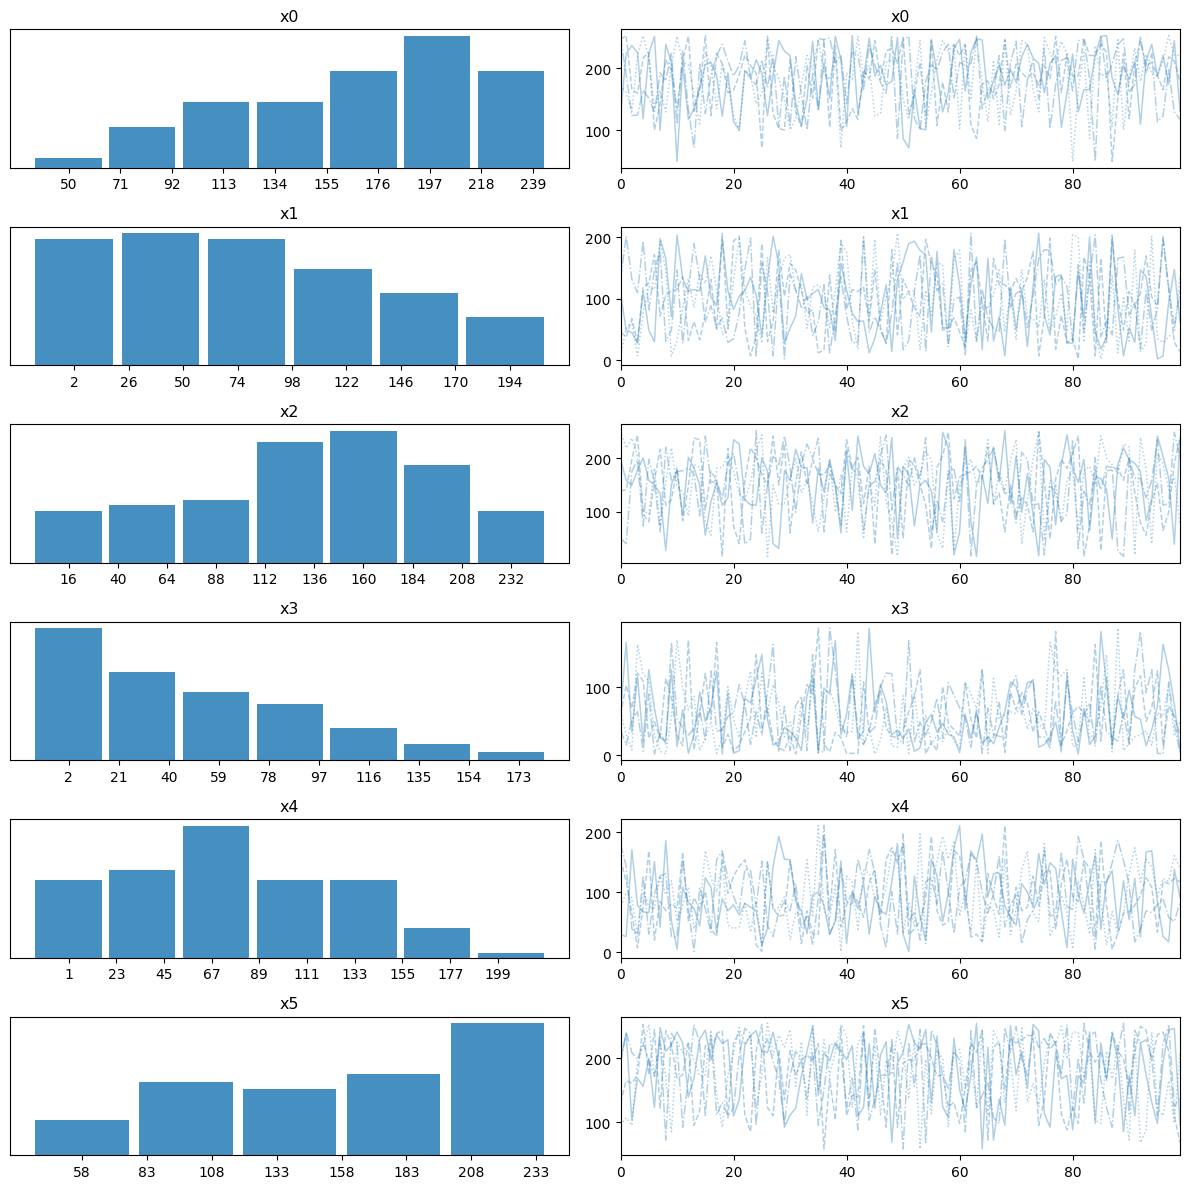

In [13]:
# Trace plot
az.plot_trace(trace);
plt.savefig('spur_trace_plot.png',dpi=150);

In [14]:
# Diagnosis
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x0,184.08,49.234,100.0,252.0,2.301,1.628,468.0,417.0,1.00
x1,97.39,57.396,7.0,199.0,2.725,1.928,452.0,331.0,1.01
x2,150.53,60.657,39.0,252.0,2.816,1.993,461.0,414.0,0.99
x3,59.46,45.566,2.0,148.0,2.120,1.507,461.0,327.0,0.99
x4,92.62,51.008,1.0,174.0,2.568,1.823,404.0,417.0,1.00
x5,180.85,54.474,92.0,255.0,2.537,1.795,509.0,392.0,1.00


In [15]:
print([(i, (trace.posterior['x0'] == i).mean().values.tolist()) for i in range(0,4)])
print([(i, (trace.posterior['x2'] == i).mean().values.tolist()) for i in range(0,7)])

[(0, 0.0), (1, 0.0), (2, 0.0), (3, 0.0)]
[(0, 0.0), (1, 0.0), (2, 0.0), (3, 0.0), (4, 0.0), (5, 0.0), (6, 0.0)]


## Non-uniform prior

Here we use the `f` parameter of our MH function to specify a prior for the variables of the SMT problem.

In particular, we consider the following very simple model

$$
x_0 \sim \mathit{Cat}(1/3, 1/3, 1/6, 1/6) ~~
x_1 \sim \mathit{U}(0,3) ~~
x_2 = x_0 + x_1
$$


In [15]:
def prior(s: dict[str, int]):
    x0 = s['x0']
    x1 = s['x0']
    p_x0 = 1/3 if x0 < 2 else 1/6
    p_x1 = 1/4

    return p_x0 * p_x1

def likelihood(s: dict[str, int]):
    return 1

In [16]:
trace = mcmc.sample_mh_trace(num_samples=num_samples, 
                             num_chains=4,
                             f = lambda s: prior(s)*likelihood(s),
                             solver_samples=solver_samples)

### Posterior analysis

We observe the in the traceplot below the effect of the prior on $x_0$. Now it is distributed as according to the categorical distribution above. As opposed to the uniform prior we used in the previous analysis.

The distribution of $x_2$ is also affected by the new prior on $x_0$.

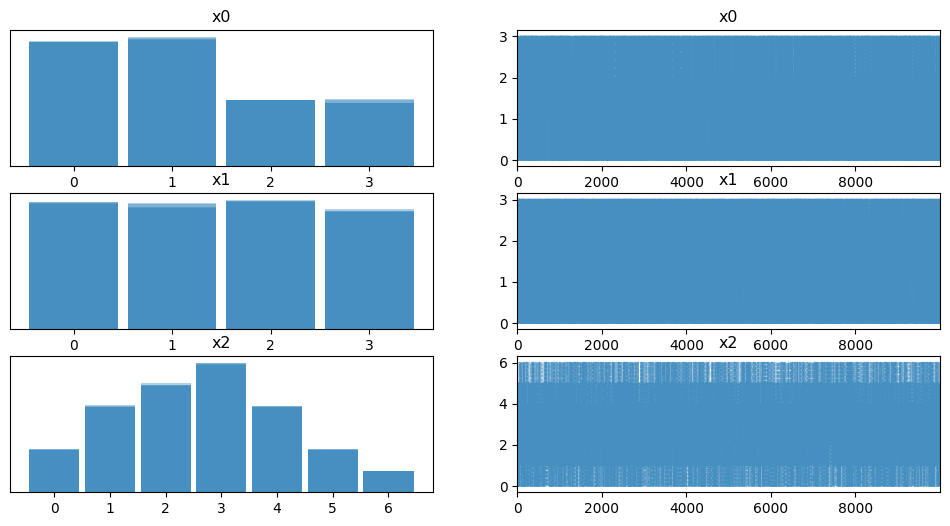

In [17]:
az.plot_trace(trace);
plt.savefig('spur_trace_plot_non_uniform.png',dpi=150);

Here we plot the probability of each outcome for $x_0$ and $x_2$

In [18]:
print([(i, (trace.posterior['x0'] == i).mean().values.tolist()) for i in range(0,4)])
print([(i, (trace.posterior['x2'] == i).mean().values.tolist()) for i in range(0,7)])

[(0, 0.3247), (1, 0.333425), (2, 0.172575), (3, 0.1693)]
[(0, 0.083075), (1, 0.1672), (2, 0.20825), (3, 0.249825), (4, 0.166675), (5, 0.08325), (6, 0.041725)]


Finally, we compare the estimated values with the analytical solution to this problem.

In [19]:
real_value_x0 = [1/3, 1/3, 1/6, 1/6]
real_value_x2 = [1/12, 1/6, 5/24, 1/4, 1/6, 1/12, 1/24]

In [20]:
print([(i, (trace.posterior['x0'] == i).mean().values.tolist() - real_value_x0[i]) for i in range(0,4)])
print([(i, (trace.posterior['x2'] == i).mean().values.tolist() - real_value_x2[i]) for i in range(0,7)])

[(0, -0.008633333333333326), (1, 9.166666666671208e-05), (2, 0.005908333333333349), (3, 0.0026333333333333486)]
[(0, -0.00025833333333333264), (1, 0.0005333333333333301), (2, -8.333333333335191e-05), (3, -0.00017500000000000848), (4, 8.333333333332416e-06), (5, -8.333333333332416e-05), (6, 5.833333333333385e-05)]


The error is low ($< 0.01$ for all variables and outcomes). However, I should remark that in other executions I observed errors up to 0.13...